# Time Series-Air Quality

Predicting Air Quality with Facebook-Prophet

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

## Importing dataset

In [2]:
data = pd.read_csv('/content/AirQualityUCI.csv', sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [3]:
data.shape

(9471, 17)

In [4]:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, how='all', inplace=True)

In [5]:
data.shape

(9357, 15)

In [6]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


## Data cleaning and Featured Engineering

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',', '.').astype('float')

In [9]:
def positive_average(num):
    return num[num > -200].mean()
    
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)

In [10]:
daily_data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,58.521739,1559.000000,670.583333,30.654167,42.120833,1.673521


In [11]:
daily_data.isna().sum() > 8

CO(GT)            True
PT08.S1(CO)      False
NMHC(GT)          True
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)           True
PT08.S3(NOx)     False
NO2(GT)           True
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

In [12]:
daily_data = daily_data.iloc[:,(daily_data.isna().sum() <= 8).values]

In [13]:
daily_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,1097.500000,8.662500,913.708333,918.083333,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,1135.583333,12.375000,1021.875000,896.791667,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,1130.583333,12.225000,1038.541667,740.916667,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,974.166667,5.808333,792.583333,880.083333,1559.000000,670.583333,30.654167,42.120833,1.673521


In [14]:
daily_data.shape

(391, 9)

In [15]:
daily_data = daily_data.dropna()

In [16]:
daily_data.shape

(383, 9)

In [17]:
weekly_data = daily_data.resample('W').mean()

In [18]:
weekly_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
weekly_data = weekly_data.dropna()

In [20]:
weekly_data.shape

(73, 9)

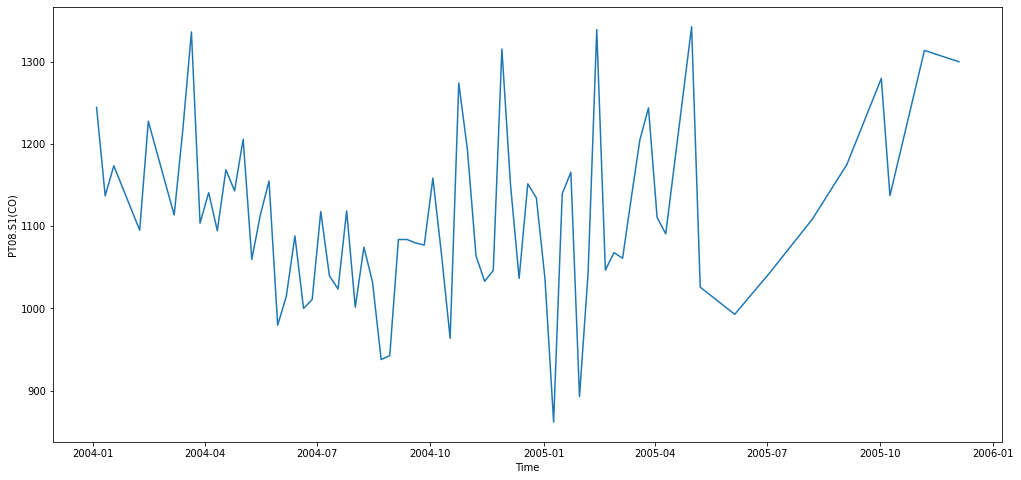

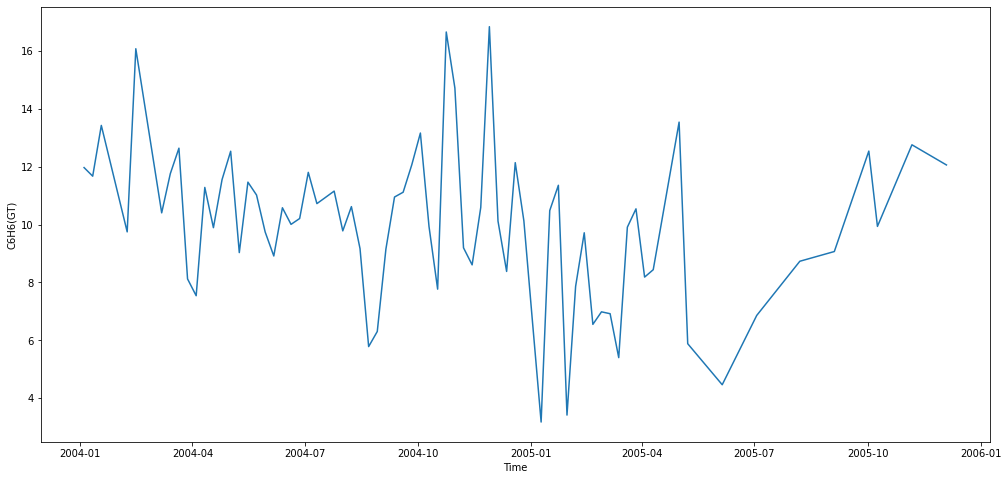

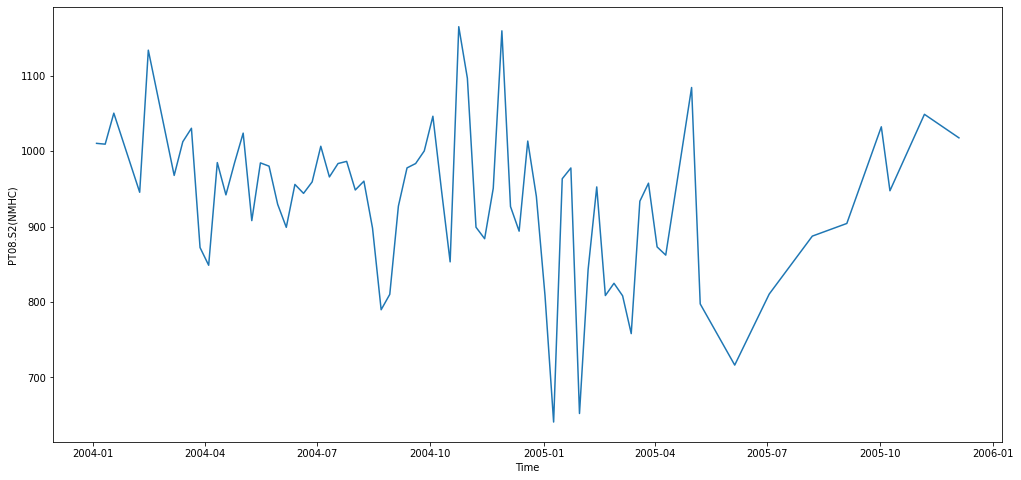

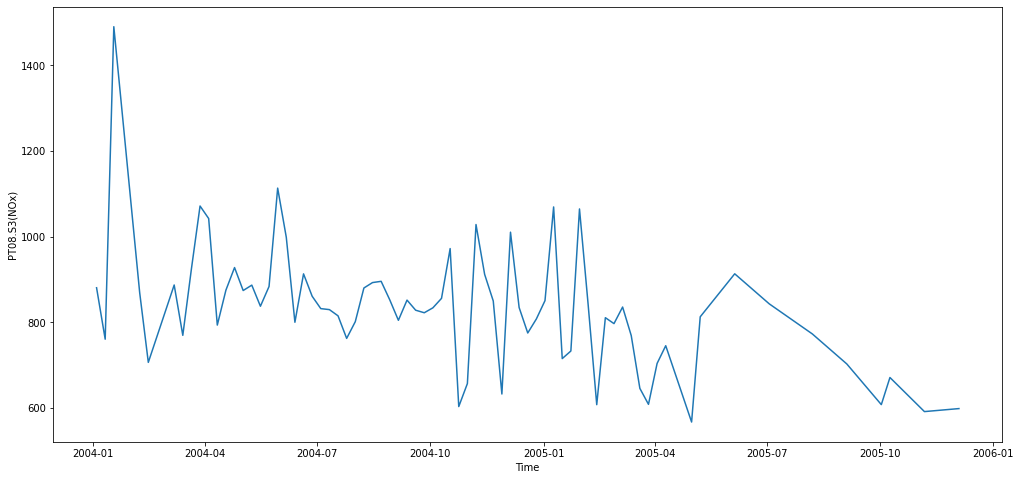

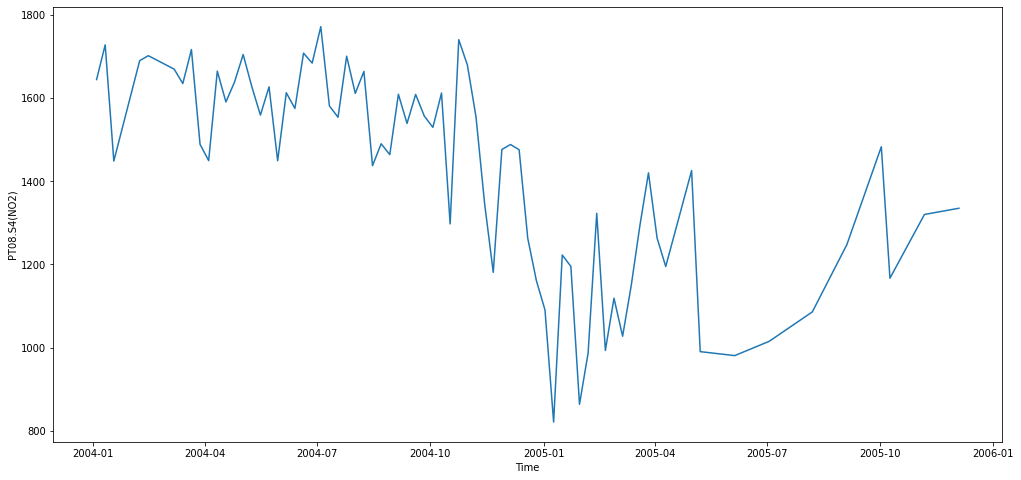

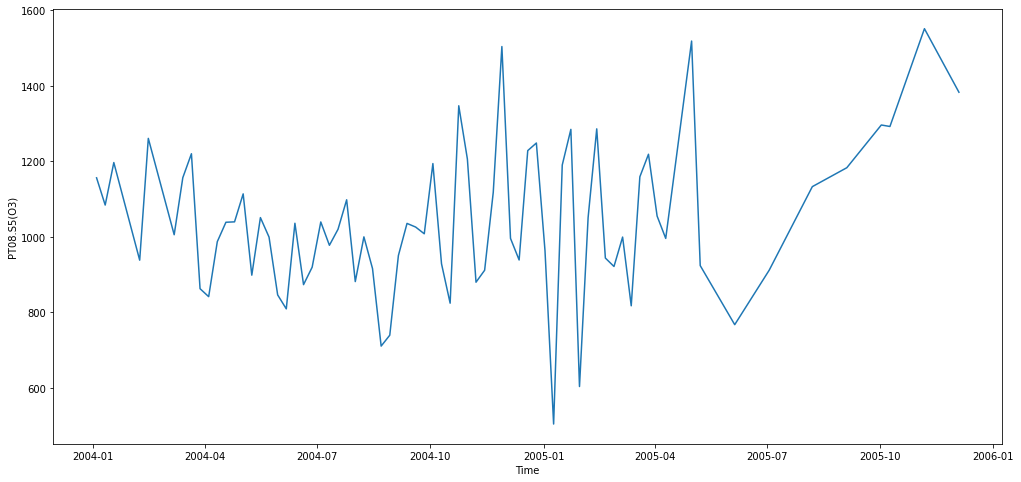

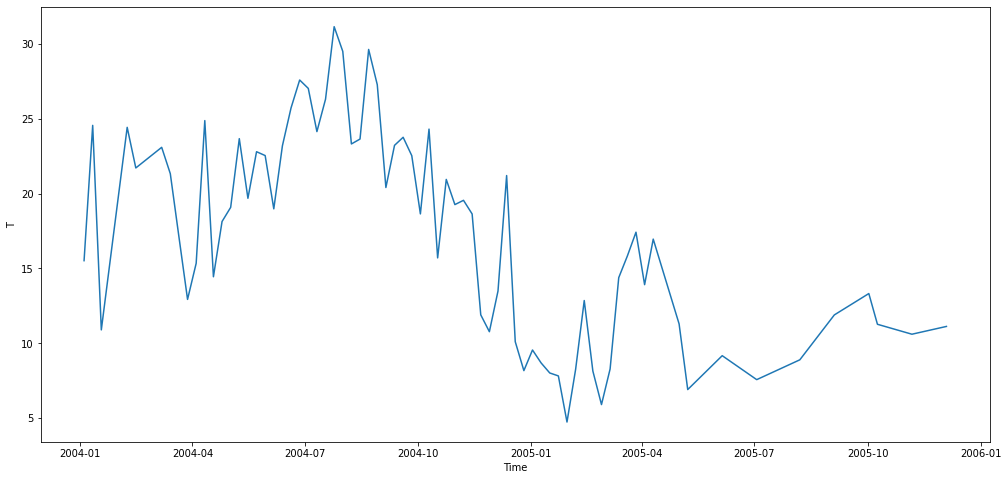

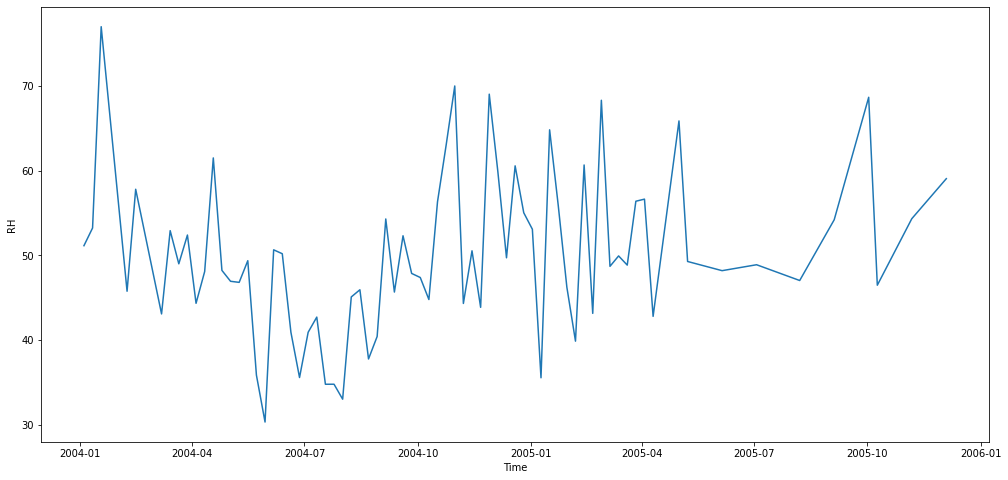

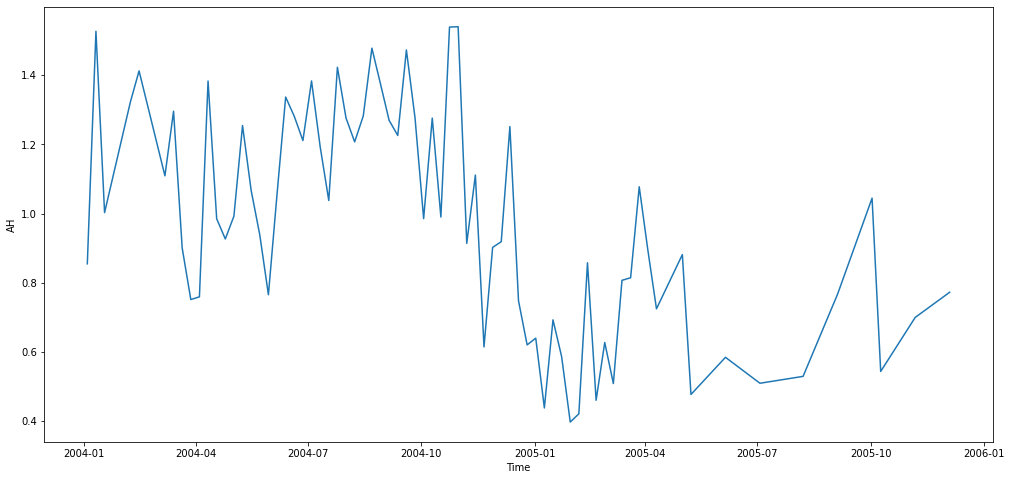

In [21]:
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

## Model Creation

Let's focus on predictig the concentration of CO. CO is believed to be one of the most common toxic gases on earth. It has no smell or color.

It is emitted from coal, gas, and diesel engines. That includes gas and oil appliances. Also, it is found in cigarette smoke and coal mines.

We're almost all exposed to it in some way but this can often lead to tragedy. For this reason, it's known as the "silent killer"

In [22]:
cols_to_drop = [ 'C6H6(GT)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

weekly_data = weekly_data.drop(cols_to_drop, axis=1)

In [23]:
weekly_data.head()

,PT08.S1(CO)
Date,
2004-01-04,1244.380952
2004-01-11,1136.801760
2004-01-18,1173.375000
2004-02-08,1095.033333
2004-02-15,1227.406250


In [24]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [25]:
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01-04,1244.380952
1,2004-01-11,1136.801760
2,2004-01-18,1173.375000
3,2004-02-08,1095.033333
4,2004-02-15,1227.406250


In [26]:
prediction_size = 30
train_df = df[:-prediction_size]

In [27]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [29]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,1170.048048,1070.393734,1263.617700,1170.048048,1170.048048,0.0,0.0,0.0,0.0,0.0,0.0,1170.048048
1,2004-01-11,1167.096943,1074.221726,1262.539835,1167.096943,1167.096943,0.0,0.0,0.0,0.0,0.0,0.0,1167.096943
2,2004-01-18,1164.145837,1060.131840,1259.967206,1164.145837,1164.145837,0.0,0.0,0.0,0.0,0.0,0.0,1164.145837
3,2004-02-08,1155.292521,1048.971100,1264.305916,1155.292521,1155.292521,0.0,0.0,0.0,0.0,0.0,0.0,1155.292521
4,2004-02-15,1152.341416,1056.451799,1247.073724,1152.341416,1152.341416,0.0,0.0,0.0,0.0,0.0,0.0,1152.341416


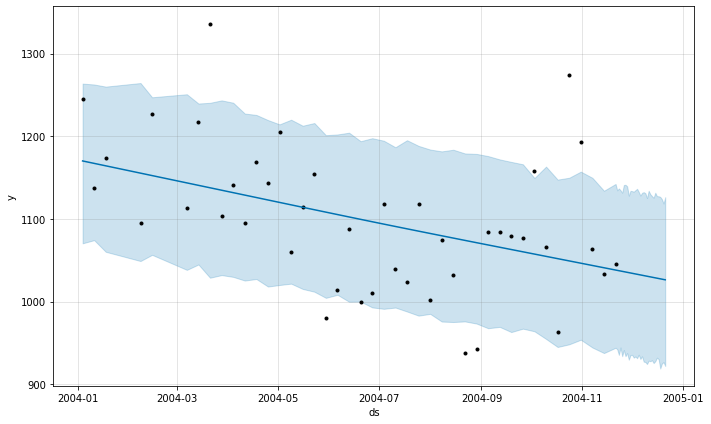

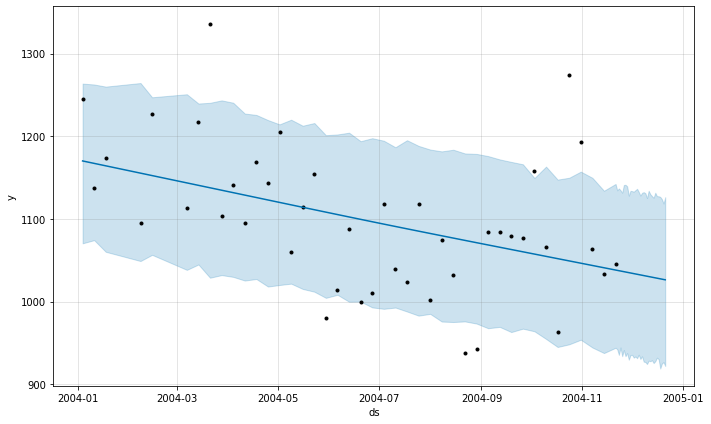

In [30]:
m.plot(forecast)

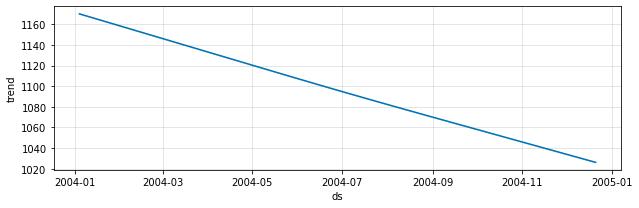

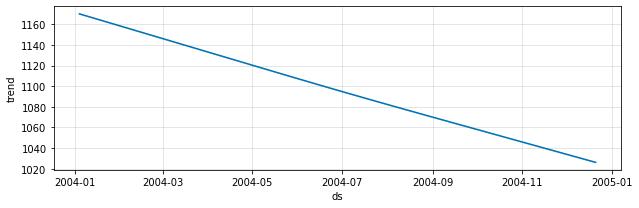

In [31]:
m.plot_components(forecast)

In [32]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [33]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2004-01-04,1170.048048,1070.393734,1263.617700,1244.380952
2004-01-11,1167.096943,1074.221726,1262.539835,1136.801760
2004-01-18,1164.145837,1060.131840,1259.967206,1173.375000
2004-02-08,1155.292521,1048.971100,1264.305916,1095.033333
2004-02-15,1152.341416,1056.451799,1247.073724,1227.406250


In [34]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [35]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 10.739652607447645
MAE 132.17060616754253


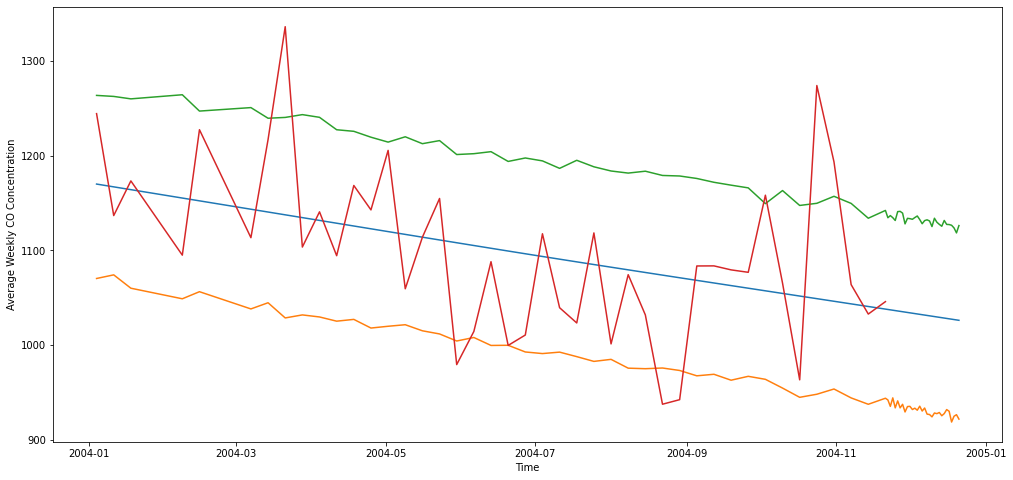

In [36]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly CO Concentration')
plt.grid(False)
plt.show()